<a href="https://colab.research.google.com/github/wross3150/Phys-142-Project/blob/main/Physics_142_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm

In [92]:
# Constants
MZ = 91.188  # GeV
Gamma_Z = 2.4414  # GeV
alpha = 1 / 132.507
GF = 1.16639e-5  # GeV^-2
sin2_thetaW = 0.222246
GeV_to_pb = 3.894e8  # pb^-1
kappa = np.sqrt(2) * GF * MZ**2 / (4 * np.pi * alpha)

# Function to calculate A0 and A1
def calculate_A0_A1(s_hat):
    Qe = -1
    Ve = -0.5 + 2 * sin2_thetaW
    Ae = -0.5
    Qmu = -1
    Vmu = -0.5 + 2 * sin2_thetaW
    Amu = -0.5
    s = s_hat
    A0 = Qe**2 - 2 * Qe * Vmu * Ve * chi1(s_hat) + (Amu**2 + Vmu**2) * (Ae**2 + Ve**2) * chi2(s_hat)
    A1 = -4 * Qe * Ae * Amu * chi1(s_hat) + 8 * Amu * Vmu * Ae * Ve * chi2(s_hat)
    return A0, A1

# Functions to calculate chi1 and chi2
def chi1(s_hat):
    s = s_hat
    return (kappa * s * (s - MZ**2)) / ((s - MZ**2)**2 + (Gamma_Z * MZ)**2)

def chi2(s_hat):
    s = s_hat
    return kappa**2 * s**2 / ((s - MZ**2)**2 + (Gamma_Z * MZ)**2)

def p(s_hat, cos_theta):
  A0, A1 = calculate_A0_A1(s_hat)
  return alpha**2 / (4 * s_hat) * (A0 * (1 + cos_theta**2) + A1 * cos_theta)

# Define X, Y boundaries

Set $x = E_{CM}$ and $y = cos(\theta)$

In [93]:
X_MIN = 10
X_MAX = 200
Y_MIN = -1
Y_MAX = 1

# Lego Plot

In [94]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    x = np.array(xAmplitudes)  # turn x,y data into numpy arrays
    y = np.array(yAmplitudes)  # useful for regular matplotlib arrays

    fig = plt.figure()  # create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection="3d")

    # make histograms - set bins
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])

    xpos = xpos.flatten() / 2.0
    ypos = ypos.flatten() / 2.0
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    cmap = mpl.cm.jet
    max_height = np.max(dz)  # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k - min_height) / max_height) for k in dz]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)
    plt.show()

# Find Maximum
using MCMC


In [157]:
def find_max(p, STEPS, X_HIT = (0.05 * 95), Y_HIT = 0.05):
  E_vals = [np.random.rand() * (X_MAX - X_MIN) + X_MIN]
  cos_vals = [np.random.rand() * (Y_MAX - Y_MIN) + Y_MIN]
  prob_vals = [p(E_vals[0] ** 2, cos_vals[0])]
  best = [E_vals[0], cos_vals[0], prob_vals[0]]
  for i in range(STEPS):
    E_diff = np.random.randn() *  X_HIT
    cos_diff = np.random.randn() * Y_HIT
    E_new = E_vals[-1] + E_diff
    cos_new = cos_vals[-1] + cos_diff
    # Check that we are in the allowed range
    if E_new > X_MAX:
      continue
    elif E_new < X_MIN:
      continue
    if cos_new > Y_MAX:
      continue
    elif cos_new < Y_MIN:
      continue
    new_prob = p(E_new ** 2, cos_new)
    if new_prob > best[2]:
      E_vals.append(E_new)
      cos_vals.append(cos_new)
      prob_vals.append(new_prob)
      best = [E_new, cos_new, new_prob]
    #To find absolute max we can comment this elif out and do multiple trials.
    elif new_prob / prob_vals[-1] > np.random.rand():
      E_vals.append(E_new)
      cos_vals.append(cos_new)
      prob_vals.append(new_prob)
  return best, E_vals, cos_vals, prob_vals

In [160]:
savedValues = np.zeros((10, 3))
for i in range(10):
  best = np.array(find_max(p,100000)[0])
  savedValues[i] = best
print(savedValues[:])

[[9.12843470e+01 9.99460338e-01 6.78563186e-07]
 [9.12469775e+01 9.95800621e-01 6.75307252e-07]
 [9.12678480e+01 9.94491123e-01 6.75012038e-07]
 [9.12719488e+01 9.99625444e-01 6.78556984e-07]
 [9.12514179e+01 9.97583589e-01 6.76671333e-07]
 [9.13886466e+01 9.97962537e-01 6.73141044e-07]
 [9.12230636e+01 9.99571843e-01 6.76693981e-07]
 [9.12882390e+01 9.99572825e-01 6.78647972e-07]
 [9.12119874e+01 9.97813329e-01 6.74790462e-07]
 [9.12786848e+01 9.91571796e-01 6.73193665e-07]]


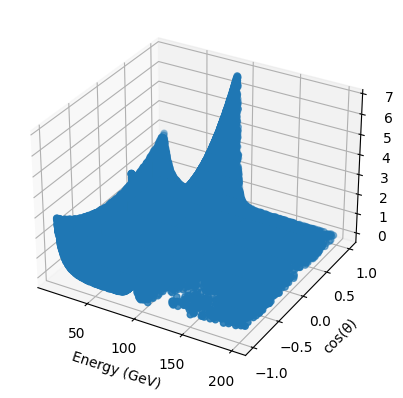

In [158]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

best, E_vals, cos_vals, prob_vals = find_max(p, 100000)
xs = E_vals
ys = cos_vals
zs = prob_vals
ax.scatter(xs, ys, zs)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(f"cos(θ)")
ax.set_zlabel(f"Probability * 10^{-7}")

plt.savefig('Maximum')
plt.show()


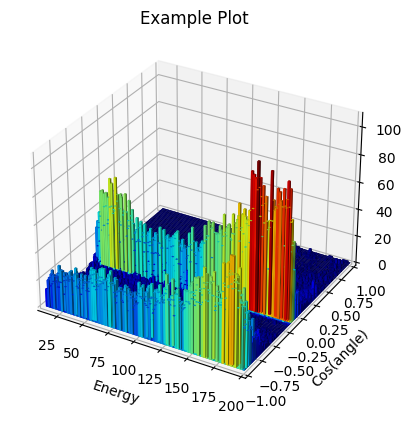

In [159]:
best, E_vals, cos_vals, prob_vals = find_max(p, 100000)
lego_plot(E_vals, cos_vals, 100, 'Energy', 'Cos(angle)', 'Example Plot')

## F_VAL_MAX Value is 6.78938033e-07

# Problem A

In [163]:
F_VAL_MAX = 6.78938033e-07
def brute_force(nPoints, seed=None):
    nFunctionEval = 0
    yy1_rej_method = []
    yy2_rej_method = []
    maxWeightEncounteredRej = -1.0e20
    generator = np.random.RandomState(seed=seed)
    while len(yy1_rej_method) < nPoints:
        rr = generator.uniform(size=3)
        yy1, yy2 = X_MIN + rr[0] * (X_MAX - X_MIN), Y_MIN + rr[1] * (Y_MAX - Y_MIN)
        nFunctionEval += 1
        f_val = p(yy1**2, yy2)
        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val
        if f_val > F_VAL_MAX:
            print(
                f" f_val={f_val} exceeds F_VAL_MAX={F_VAL_MAX}, program will now exit"
            )
            exit(99)
        if f_val / F_VAL_MAX > rr[2]:
            yy1_rej_method.append(yy1)
            yy2_rej_method.append(yy2)
    return {
        "yy1": yy1_rej_method,
        "yy2": yy2_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
    }

In [168]:
nPoints = 100000
bf = brute_force(nPoints)

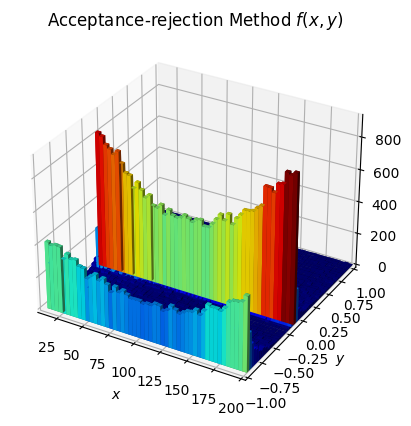

In [169]:
print(bf['nFunEval'])
nBins = 50
titleRej = r"Acceptance-rejection Method $f(x,y)$"
lego_plot(bf["yy1"], bf["yy2"], nBins, "$x$", "$y$", titleRej)
plt.show()

# Problem B

## Setup Intervals

In [100]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [X_MIN, X_MAX] or [Y_MIN, Y_MAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between X_MIN/Y_MIN and X_MAX/Y_MAX
    xLow = X_MIN + (X_MAX - X_MIN) / NN * np.arange(NN + 1)
    delx = np.ones(NN) * (X_MAX - X_MIN) / NN
    px = np.ones(NN) / (X_MAX - X_MIN)  # probability density in each interval
    yLow = Y_MIN + Y_MAX / NN * np.arange(NN + 1)
    dely = np.ones(NN) * (Y_MAX - Y_MIN) / NN
    py = np.ones(NN) / (Y_MAX - Y_MIN)

    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = f(xx, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum

        """mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)"""
        mmx = KK * logArgx
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        """mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)"""
        mmy = KK * logArgy
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)

        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]
        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely

## Vegas

In [101]:
def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + delx[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = f(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

# Additional Code